In [2]:
import sklearn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas
import mplhep

import sys
sys.path += ["../test"]

import train_end2end
%matplotlib inline

setGPU: Setting GPU to: 3
torch 1.4.0
torch_geometric 1.4.3


In [3]:
def cms_label(x0=0.12, x1=0.23, x2=0.67, y=0.90):
    plt.figtext(x0, y,'CMS',fontweight='bold', wrap=True, horizontalalignment='left', fontsize=12)
    plt.figtext(x1, y,'Simulation Preliminary', style='italic', wrap=True, horizontalalignment='left', fontsize=10)
    plt.figtext(x2, y,'Run 3 (14 TeV)',  wrap=True, horizontalalignment='left', fontsize=10)

def sample_label(ax, y=0.98):
    plt.text(0.03, y, "$\mathrm{t}\overline{\mathrm{t}}$ events", va="top", ha="left", size=10, transform=ax.transAxes)
    
pid_to_text = {
    211: r"charged hadrons ($\pi^-$, ...)",
    -211: r"charged hadrons ($\pi^+$, ...)",
    130: r"neutral hadrons (K, ...)",
    1: r"HF hadron (EM)",
    2: r"HF-HAD hadron (HAD)",
}
def particle_label(ax, pid):
    plt.text(0.03, 0.92, pid_to_text[pid], va="top", ha="left", size=10, transform=ax.transAxes)

In [4]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm[np.isnan(cm)] = 0.0

    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:0.1f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.ylabel('True label')
    plt.xlim(-1, len(target_names))
    plt.ylim(-1, len(target_names))
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.tight_layout()
    
    return fig, ax

In [5]:
!rm *.pdf

In [6]:
def deltaphi(phi1, phi2):
    return np.fmod(phi1 - phi2 + np.pi, 2*np.pi) - np.pi

In [7]:
# model = "PFNet7_TTbar_14TeV_TuneCUETP8M1_cfi_gen__npar_3440145__cfg_4ff944b45d__user_jpata__ntrain_3600__lr_1e-05__1587059029"
# epoch = 45
# big_df = pandas.read_pickle("../data/{}/epoch_{}/df.pkl.bz2".format(model, epoch))
# #big_df = pandas.read_pickle("../test/TTbar_14TeV_TuneCUETP8M1_cfi.pkl.bz2")

big_df = pandas.read_pickle("/storage/user/jpata/particleflow/experiments/run_1/df_1.pkl.bz2")
big_df["pred_phi"] = np.arctan2(np.sin(big_df["pred_phi"]), np.cos(big_df["pred_phi"]))

# big_df2 = pandas.read_pickle("../experiments/run_2/df_1.pkl.bz2")
# big_df2["pred_phi"] = np.arctan2(np.sin(big_df2["pred_phi"]), np.cos(big_df2["pred_phi"]))

targettype = "cand"

In [8]:
#msk = (big_df["target_pid"] != 0) & ((big_df["pred_pid"] != 0))
msk = np.ones(len(big_df), dtype=np.bool)
confusion2 = sklearn.metrics.confusion_matrix(
    big_df["target_pid"][msk], big_df["pred_pid"][msk],
    labels=train_end2end.class_labels
)


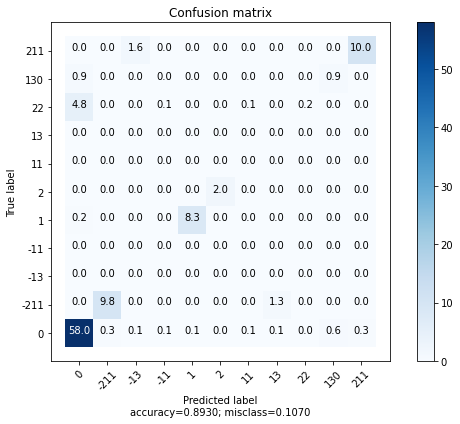

In [9]:
fig, ax = plot_confusion_matrix(
    cm=100.0*confusion2/np.sum(confusion2), target_names=[int(x) for x in train_end2end.class_labels], normalize=False
)

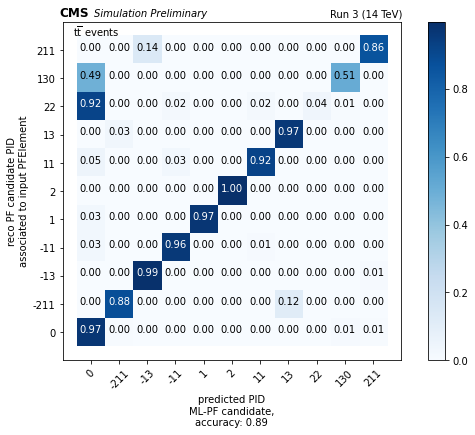

In [10]:
fig, ax = plot_confusion_matrix(
    cm=confusion2, target_names=[int(x) for x in train_end2end.class_labels], normalize=True
)

acc = sklearn.metrics.accuracy_score(big_df["target_pid"][msk], big_df["pred_pid"][msk])
plt.title("")
#plt.title("ML-PF, accuracy={:.2f}".format(acc))
plt.ylabel("reco PF candidate PID\nassociated to input PFElement")
plt.xlabel("predicted PID\nML-PF candidate,\naccuracy: {:.2f}".format(acc))
cms_label(x0=0.20, x1=0.26, y=0.95)
sample_label(ax, y=0.995)
plt.savefig("confusion_mlpf.pdf", bbox_inches="tight")

In [11]:
bins, counts = np.unique(big_df.loc[big_df["target_pid"]!=0, "target_pid"], return_counts=True)
bins, counts2 = np.unique(big_df.loc[big_df["pred_pid"]!=0, "pred_pid"], return_counts=True)

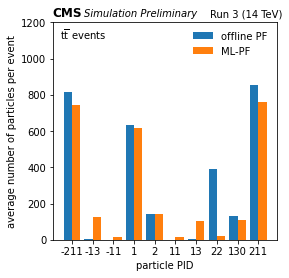

In [12]:
plt.figure(figsize=(4,4))
ax = plt.axes()
xs = np.arange(len(counts))
plt.bar(xs, counts/500.0, width=0.4, label="offline PF")
plt.bar(xs+0.4, counts2/500.0, width=0.4, label="ML-PF")
plt.xticks(xs+0.2, bins);
plt.ylabel("average number of particles per event")
plt.xlabel("particle PID")
plt.ylim(0,1200)
plt.legend(loc="best", frameon=False)
cms_label()
sample_label(ax)

In [13]:
num_cands = []
num_preds = []

sum_e_true = []
sum_e_pred = []

for k, v in big_df.groupby("iev"):
    
    num_cand = 0
    num_pred = 0
    for pid in [211, -211, 130, 22, 11, -11, 13, -13, 1, 2]:
        if pid == 0:
            continue
        num_cand += np.sum(v["target_pid"] == pid)
        num_pred += np.sum(v["pred_pid"] == pid)
    num_cands += [num_cand]
    num_preds += [num_pred]
    
    sum_e_true += [np.sum(v["target_e"])/len(v)]
    sum_e_pred += [np.sum(v["pred_e"])/len(v)]
    
sum_e_true = np.array(sum_e_true)
sum_e_pred = np.array(sum_e_pred)

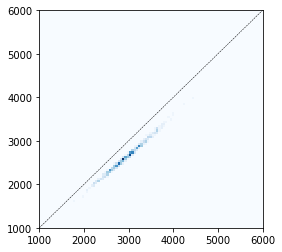

In [14]:
plt.figure(figsize=(4,4))
min_num = 1000
max_num = 6000
hist = np.histogram2d(num_cands, num_preds, bins=(np.linspace(min_num, max_num,100), np.linspace(min_num, max_num,100)))
mplhep.hist2dplot(hist[0], hist[1], hist[2], cbar=False, cmap="Blues")
plt.plot([min_num, max_num], [min_num, max_num], ls="--", lw=0.5, color="black")

#plt.xlabel("True hadron multiplicity $|\eta| < 3.0$")
#plt.ylabel("Predicted hadron multiplicity $|\eta| < 3.0$")

In [15]:
def get_eff(df, pid):
    v0 = np.sum(df==pid)
    return v0 / len(df), np.sqrt(v0)/len(df)

def get_fake(df, pid):
    v0 = np.sum(df!=pid)
    return v0 / len(df), np.sqrt(v0)/len(df)

In [16]:
def plot_E_reso(pid, v0, msk_true, msk_pred, msk_both, bins):
    plt.figure(figsize=(4,4))
    ax = plt.axes()
    hist = np.histogram2d(v0[msk_both, 0], v0[msk_both, 1], bins=(bins["E_val"], bins["E_val"]))
    mplhep.hist2dplot(hist[0], hist[1], hist[2], cmap="Blues", cbar=False);
    plt.xlabel(bins["true_val"] + " " + bins["E_xlabel"])
    plt.ylabel(bins["pred_val"]+ " " + bins["E_xlabel"])
    cms_label()
    sample_label(ax)
    particle_label(ax, pid)
    plt.plot(
        [bins["E_val"][0], bins["E_val"][-1]],
        [bins["E_val"][0], bins["E_val"][-1]],
        color="black", ls="--", lw=0.5)
    plt.savefig("energy_2d_pid{}.pdf".format(pid), bbox_inches="tight")
    
    plt.figure(figsize=(4,4))
    ax = plt.axes()
    plt.hist(v0[msk_true, 0], bins=bins["E_val"], density=1.0, histtype="step", lw=2, label=bins["true_val"]);
    plt.hist(v0[msk_pred, 1], bins=bins["E_val"], density=1.0, histtype="step", lw=2, label=bins["pred_val"]);
    plt.xlabel(bins["E_xlabel"])
    plt.ylabel("number of particles\n(normalized, a.u.)")
    plt.legend(frameon=False)
    cms_label()
    sample_label(ax)
    particle_label(ax, pid)
    ax.set_ylim(ax.get_ylim()[0], 1.5*ax.get_ylim()[1])
    plt.savefig("energy_hist_pid{}.pdf".format(pid), bbox_inches="tight")
    
    ax.set_ylim(ax.get_ylim()[0], 1.2*ax.get_ylim()[1])

    res = (v0[msk_both, 1] - v0[msk_both, 0])/v0[msk_both, 0]
    res[np.isnan(res)] = -1

    plt.figure(figsize=(4,4))
    ax = plt.axes()
    ax.text(0.98, 0.98, "avg. $\Delta E / E$\n$%.2f \pm %.2f$"%(np.mean(res), np.std(res)), transform=ax.transAxes, ha="right", va="top")
    plt.hist(res, bins=bins["E_res"], density=1.0);
    plt.xlabel("$\Delta E / E$")
    plt.ylabel("number of particles\n(normalized, a.u.)")
    cms_label()
    sample_label(ax)
    particle_label(ax, pid)
    plt.savefig("energy_ratio_pid{}.pdf".format(pid), bbox_inches="tight")
    
    #efficiency vs fake rate
    plt.figure(figsize=(4,4))
    ax = plt.axes()
    big_df["bins_target_e"] = np.searchsorted(bins["E_val"], big_df["target_e"])
    big_df["bins_pred_e"] = np.searchsorted(bins["E_val"], big_df["pred_e"])

    vals_eff = big_df[(big_df["target_pid"]==pid)].groupby("bins_target_e")["pred_pid"].apply(get_eff, pid)
    vals_fake = big_df[(big_df["pred_pid"]==pid)].groupby("bins_pred_e")["target_pid"].apply(get_fake, pid)

    out_eff = np.zeros((len(bins["E_val"]), 2))
    out_fake = np.zeros((len(bins["E_val"]), 2))
    for ib in range(len(bins["E_val"])):
        if ib in vals_eff.keys():
            out_eff[ib, 0] = vals_eff[ib][0]
            out_eff[ib, 1] = vals_eff[ib][1]
        if ib in vals_fake.keys():
            out_fake[ib, 0] = vals_fake[ib][0]
            out_fake[ib, 1] = vals_fake[ib][1]

    cms_label()
    sample_label(ax)
    particle_label(ax, pid)

    plt.errorbar(bins["E_val"], out_eff[:, 0], out_eff[:, 1], marker=".", lw=0, elinewidth=1.0, color="green", label="efficiency")
    plt.ylabel("efficiency\nN(pred|true) / N(true)")
    ax.set_ylim(0, 1.5)
    plt.xlabel(bins["E_xlabel"])

    ax2 = ax.twinx()
    col = "red"
    plt.errorbar(bins["E_val"], out_fake[:, 0], out_fake[:, 1], marker=".", lw=0, elinewidth=1.0, color=col, label="fake rate")
    plt.ylabel("fake rate\nN(true|pred) / N(pred)")
    plt.xlabel(bins["E_xlabel"])
    ax2.set_ylim(0, 1.5)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0, frameon=False)
    plt.savefig("energy_eff_fake_pid{}.pdf".format(pid), bbox_inches="tight")


In [660]:
def plot_eta_reso(pid, v0, msk_true, msk_pred, msk_both, bins):
    plt.figure(figsize=(4,4))
    ax = plt.axes()
    hist = np.histogram2d(v0[msk_both, 0], v0[msk_both, 1], bins=(bins["eta_val"], bins["eta_val"]))
    mplhep.hist2dplot(hist[0], hist[1], hist[2], cmap="Blues", cbar=False);
    plt.xlabel(bins["true_val"] + " " + bins["eta_xlabel"])
    plt.ylabel(bins["pred_val"]+ " " + bins["eta_xlabel"])
    cms_label()
    sample_label(ax)
    particle_label(ax, pid)
    plt.plot(
        [bins["eta_val"][0], bins["eta_val"][-1]],
        [bins["eta_val"][0], bins["eta_val"][-1]],
        color="black", ls="--", lw=0.5)
    plt.savefig("eta_2d_pid{}.pdf".format(pid), bbox_inches="tight")
    
    plt.figure(figsize=(4,4))
    ax = plt.axes()
    plt.hist(v0[msk_true, 0], bins=bins["eta_val"], density=1.0, histtype="step", lw=2, label=bins["true_val"]);
    plt.hist(v0[msk_pred, 1], bins=bins["eta_val"], density=1.0, histtype="step", lw=2, label=bins["pred_val"]);
    plt.xlabel(bins["eta_xlabel"])
    plt.ylabel("number of particles\n(normalized, a.u.)")
    plt.legend(frameon=False)
    cms_label()
    sample_label(ax)
    particle_label(ax, pid)
    ax.set_ylim(ax.get_ylim()[0], 1.5*ax.get_ylim()[1])
    plt.savefig("eta_hist_pid{}.pdf".format(pid), bbox_inches="tight")
    
    ax.set_ylim(ax.get_ylim()[0], 1.2*ax.get_ylim()[1])

    res = (v0[msk_both, 1] - v0[msk_both, 0])
    res[np.isnan(res)] = -1

    plt.figure(figsize=(4,4))
    ax = plt.axes()
    ax.text(0.98, 0.98, "avg. $\Delta \eta$\n$%.2f \pm %.2f$"%(np.mean(res), np.std(res)), transform=ax.transAxes, ha="right", va="top")
    plt.hist(res, bins=bins["eta_res"], density=1.0);
    plt.xlabel("$\Delta \eta$")
    plt.ylabel("number of particles\n(normalized, a.u.)")
    cms_label()
    sample_label(ax)
    particle_label(ax, pid)
    plt.savefig("eta_ratio_pid{}.pdf".format(pid), bbox_inches="tight")
    
    #efficiency vs fake rate
    plt.figure(figsize=(4,4))
    ax = plt.axes()
    big_df["bins_target_eta"] = np.searchsorted(bins["eta_val"], big_df["target_eta"])
    big_df["bins_pred_eta"] = np.searchsorted(bins["eta_val"], big_df["pred_eta"])

    vals_eff = big_df[(big_df["target_pid"]==pid)].groupby("bins_target_eta")["pred_pid"].apply(get_eff, pid)
    vals_fake = big_df[(big_df["pred_pid"]==pid)].groupby("bins_pred_eta")["target_pid"].apply(get_fake, pid)

    out_eff = np.zeros((len(bins["eta_val"]), 2))
    out_fake = np.zeros((len(bins["eta_val"]), 2))
    for ib in range(len(bins["eta_val"])):
        if ib in vals_eff.keys():
            out_eff[ib, 0] = vals_eff[ib][0]
            out_eff[ib, 1] = vals_eff[ib][1]
        if ib in vals_fake.keys():
            out_fake[ib, 0] = vals_fake[ib][0]
            out_fake[ib, 1] = vals_fake[ib][1]

    cms_label()
    sample_label(ax)
    particle_label(ax, pid)

    plt.errorbar(bins["eta_val"], out_eff[:, 0], out_eff[:, 1], marker=".", lw=0, elinewidth=1.0, color="green", label="efficiency")
    plt.ylabel("efficiency\nN(pred|true) / N(true)")
    ax.set_ylim(0, 1.5)
    plt.xlabel(bins["eta_xlabel"])

    ax2 = ax.twinx()
    col = "red"
    plt.errorbar(bins["eta_val"], out_fake[:, 0], out_fake[:, 1], marker=".", lw=0, elinewidth=1.0, color=col, label="fake rate")
    plt.ylabel("fake rate\nN(true|pred) / N(pred)")
    plt.xlabel(bins["eta_xlabel"])
    ax2.set_ylim(0, 1.5)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0, frameon=False)
    plt.savefig("eta_eff_fake_pid{}.pdf".format(pid), bbox_inches="tight")


In [661]:
def plot_phi_reso(pid, v0, msk_true, msk_pred, msk_both, bins):
    plt.figure(figsize=(4,4))
    ax = plt.axes()
    hist = np.histogram2d(v0[msk_both, 0], v0[msk_both, 1], bins=(bins["phi_val"], bins["phi_val"]))
    mplhep.hist2dplot(hist[0], hist[1], hist[2], cmap="Blues", cbar=False);
    plt.xlabel(bins["true_val"] + " " + bins["phi_xlabel"])
    plt.ylabel(bins["pred_val"]+ " " + bins["phi_xlabel"])
    cms_label()
    sample_label(ax)
    particle_label(ax, pid)
    plt.plot(
        [bins["phi_val"][0], bins["phi_val"][-1]],
        [bins["phi_val"][0], bins["phi_val"][-1]],
        color="black", ls="--", lw=0.5)
    plt.savefig("phi_2d_pid{}.pdf".format(pid), bbox_inches="tight")
    
    plt.figure(figsize=(4,4))
    ax = plt.axes()
    plt.hist(v0[msk_true, 0], bins=bins["phi_val"], density=1.0, histtype="step", lw=2, label=bins["true_val"]);
    plt.hist(v0[msk_pred, 1], bins=bins["phi_val"], density=1.0, histtype="step", lw=2, label=bins["pred_val"]);
    plt.xlabel(bins["phi_xlabel"])
    plt.ylabel("number of particles\n(normalized, a.u.)")
    plt.legend(frameon=False)
    cms_label()
    sample_label(ax)
    particle_label(ax, pid)
    plt.savefig("phi_hist_pid{}.pdf".format(pid), bbox_inches="tight")
    ax.set_ylim(ax.get_ylim()[0], 1.5*ax.get_ylim()[1])

    res = (v0[msk_both, 1] - v0[msk_both, 0])
    res[np.isnan(res)] = -1

    plt.figure(figsize=(4,4))
    ax = plt.axes()
    ax.text(0.98, 0.98, "avg. $\Delta \phi$\n$%.2f \pm %.2f$"%(np.mean(res), np.std(res)), transform=ax.transAxes, ha="right", va="top")
    plt.hist(res, bins=bins["phi_res"], density=1.0);
    plt.xlabel("$\Delta \phi$")
    plt.ylabel("number of particles\n(normalized, a.u.)")
    cms_label()
    sample_label(ax)
    particle_label(ax, pid)
    plt.savefig("phi_ratio_pid{}.pdf".format(pid), bbox_inches="tight")
    
    #efficiency vs fake rate
    plt.figure(figsize=(4,4))
    ax = plt.axes()
    big_df["bins_target_phi"] = np.searchsorted(bins["phi_val"], big_df["target_phi"])
    big_df["bins_pred_phi"] = np.searchsorted(bins["phi_val"], big_df["pred_phi"])

    vals_eff = big_df[(big_df["target_pid"]==pid)].groupby("bins_target_phi")["pred_pid"].apply(get_eff, pid)
    vals_fake = big_df[(big_df["pred_pid"]==pid)].groupby("bins_pred_phi")["target_pid"].apply(get_fake, pid)

    out_eff = np.zeros((len(bins["phi_val"]), 2))
    out_fake = np.zeros((len(bins["phi_val"]), 2))
    for ib in range(len(bins["phi_val"])):
        if ib in vals_eff.keys():
            out_eff[ib, 0] = vals_eff[ib][0]
            out_eff[ib, 1] = vals_eff[ib][1]
        if ib in vals_fake.keys():
            out_fake[ib, 0] = vals_fake[ib][0]
            out_fake[ib, 1] = vals_fake[ib][1]

    cms_label()
    sample_label(ax)
    particle_label(ax, pid)

    plt.errorbar(bins["phi_val"], out_eff[:, 0], out_eff[:, 1], marker=".", lw=0, elinewidth=1.0, color="green", label="efficiency")
    plt.ylabel("efficiency\nN(pred|true) / N(true)")
    ax.set_ylim(0, 1.5)
    plt.xlabel(bins["phi_xlabel"])

    ax2 = ax.twinx()
    col = "red"
    plt.errorbar(bins["phi_val"], out_fake[:, 0], out_fake[:, 1], marker=".", lw=0, elinewidth=1.0, color=col, label="fake rate")
    plt.ylabel("fake rate\nN(true|pred) / N(pred)")
    plt.xlabel(bins["phi_xlabel"])
    ax2.set_ylim(0, 1.5)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0, frameon=False)
    plt.savefig("phi_eff_fake_pid{}.pdf".format(pid), bbox_inches="tight")

In [662]:
def prepare_resolution_plots(big_df, pid, bins):

    msk_true = (big_df["target_pid"]==pid)
    msk_pred = (big_df["pred_pid"]==pid)
    msk_both = msk_true&msk_pred
    v0 = big_df[["target_e", "pred_e"]].values
    v1 = big_df[["target_eta", "pred_eta"]].values
    v2 = big_df[["target_phi", "pred_phi"]].values
    
    plot_E_reso(pid, v0, msk_true, msk_pred, msk_both, bins)
    plot_eta_reso(pid, v1, msk_true, msk_pred, msk_both, bins)
    plot_phi_reso(pid, v2, msk_true, msk_pred, msk_both, bins)

In [663]:
bins = {
    211: {
        "E_val": np.linspace(0, 5, 61),
        "E_res": np.linspace(-1, 1, 61),
        "eta_val": np.linspace(-4, 4, 61),
        "eta_res": np.linspace(-0.5, 0.5, 61),
        "E_xlabel": "Energy [GeV]",
        "eta_xlabel": "$\eta$",
        "phi_val": np.linspace(-4, 4, 61),
        "phi_res": np.linspace(-0.5, 0.5, 41),
        "phi_xlabel": "Energy [GeV]",
        "phi_xlabel": "$\phi$",
        "true_val": "reco PF",
        "pred_val": "ML-PF",
    },
    -211: {
        "E_val": np.linspace(0, 5, 61),
        "E_res": np.linspace(-1, 1, 61),
        "eta_val": np.linspace(-4, 4, 61),
        "eta_res": np.linspace(-0.5, 0.5, 41),
        "E_xlabel": "Energy [GeV]",
        "eta_xlabel": "$\eta$",
        "phi_val": np.linspace(-4, 4, 61),
        "phi_res": np.linspace(-0.5, 0.5, 41),
        "phi_xlabel": "Energy [GeV]",
        "phi_xlabel": "$\phi$",
        "true_val": "reco PF",
        "pred_val": "ML-PF",
    },
    130: {
        "E_val": np.linspace(0, 10, 61),
        "E_res": np.linspace(-1, 1, 61),
        "eta_val": np.linspace(-4, 4, 61),
        "eta_res": np.linspace(-0.5, 0.5, 41),
        "E_xlabel": "Energy [GeV]",
        "eta_xlabel": "$\eta$",
        "phi_val": np.linspace(-4, 4, 61),
        "phi_res": np.linspace(-0.5, 0.5, 41),
        "phi_xlabel": "Energy [GeV]",
        "phi_xlabel": "$\phi$",
        "true_val": "reco PF",
        "pred_val": "ML-PF",
    },
    1: {
        "E_val": np.linspace(0, 100, 61),
        "E_res": np.linspace(-1, 1, 61),
        "xlabel": "Energy [GeV]",
        "true_val": "reco PF",
        "pred_val": "ML-PF",
    },
    2: {
        "E_val": np.linspace(0, 50, 61),
        "E_res": np.linspace(-1, 1, 61),
        "xlabel": "Energy [GeV]",
        "true_val": "reco PF",
        "pred_val": "ML-PF",
    }
}

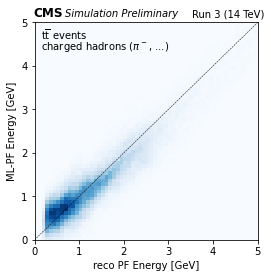

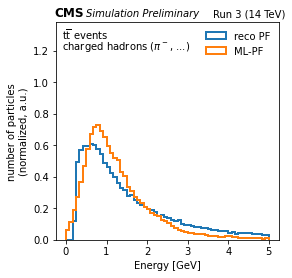

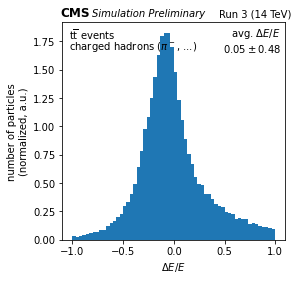

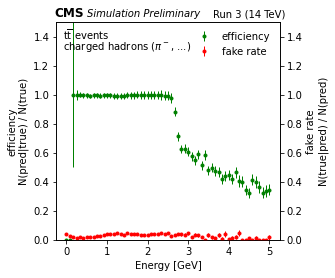

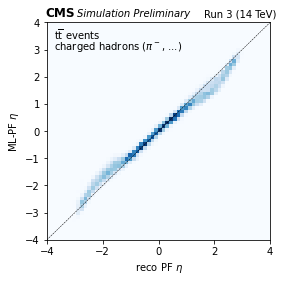

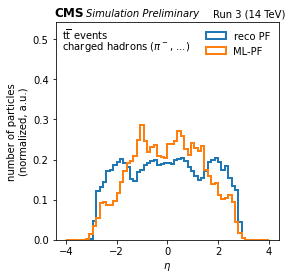

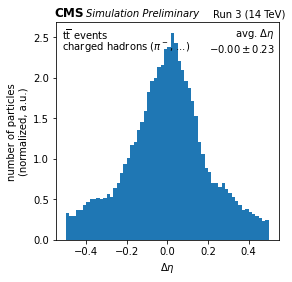

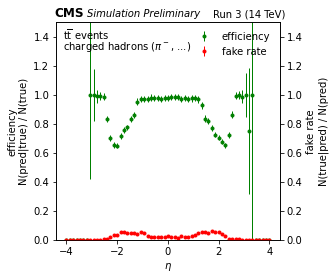

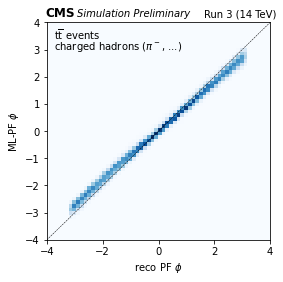

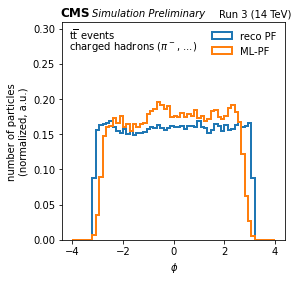

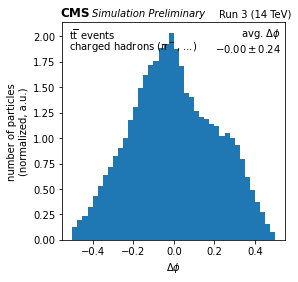

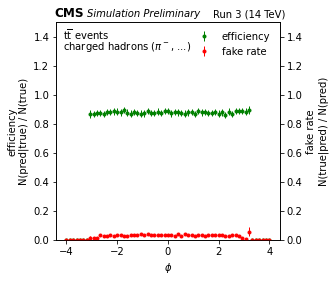

In [664]:
prepare_resolution_plots(big_df, 211, bins[211])

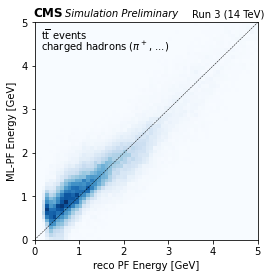

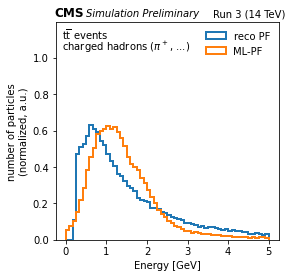

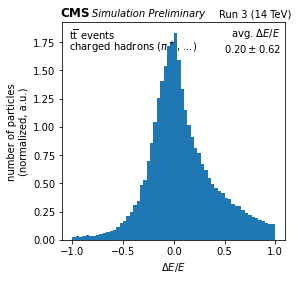

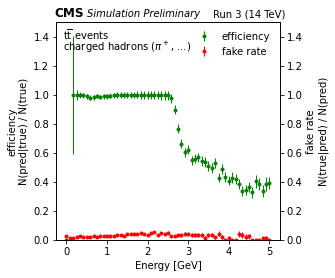

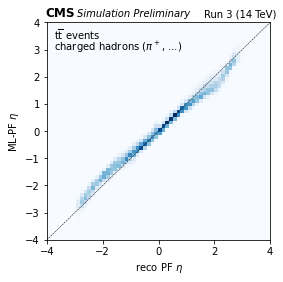

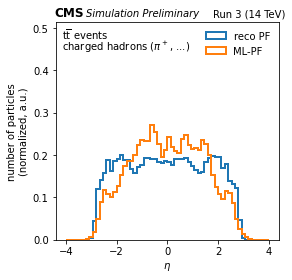

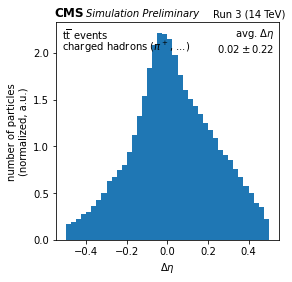

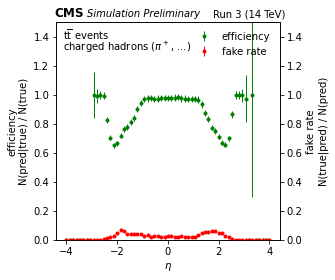

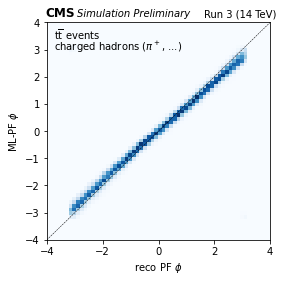

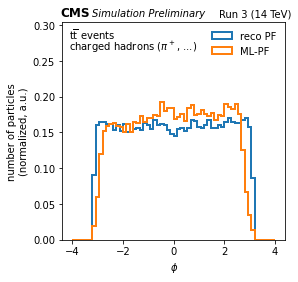

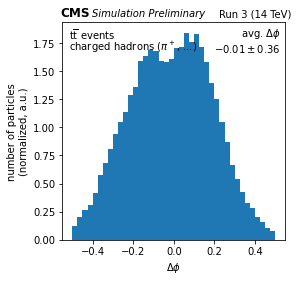

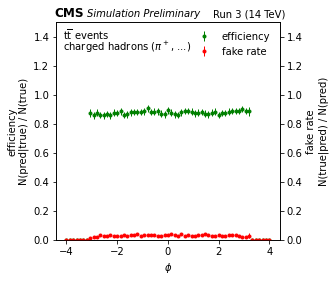

In [665]:
prepare_resolution_plots(big_df, -211, bins[-211])

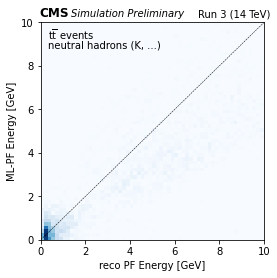

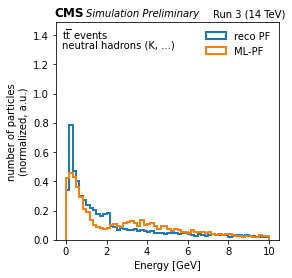

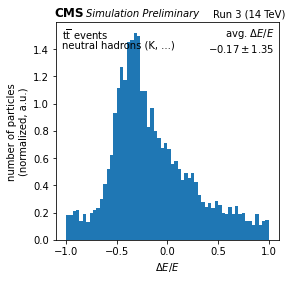

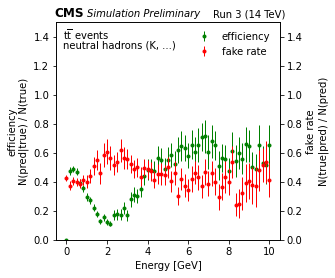

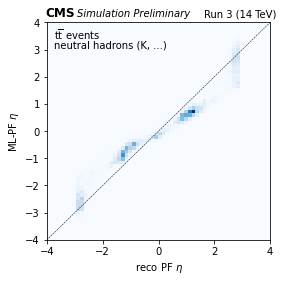

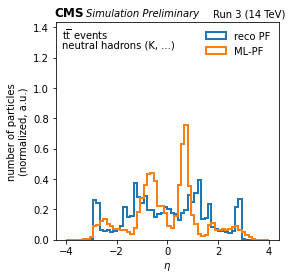

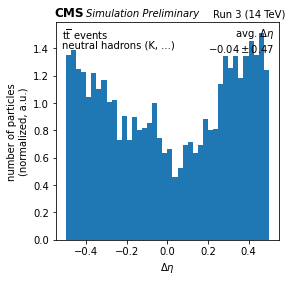

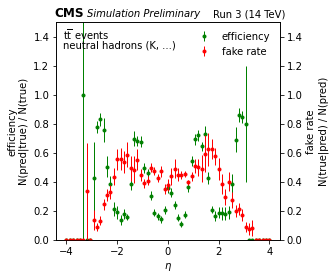

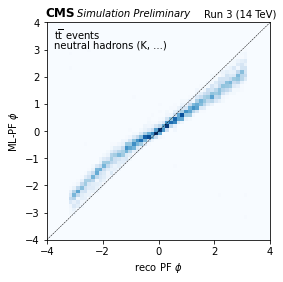

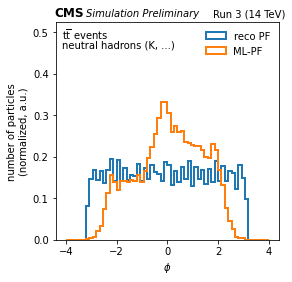

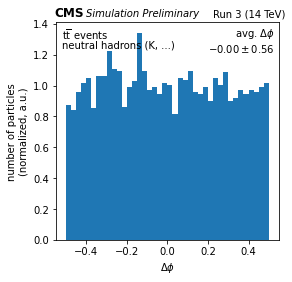

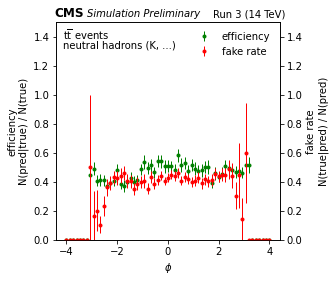

In [666]:
prepare_resolution_plots(big_df, 130, bins[130])

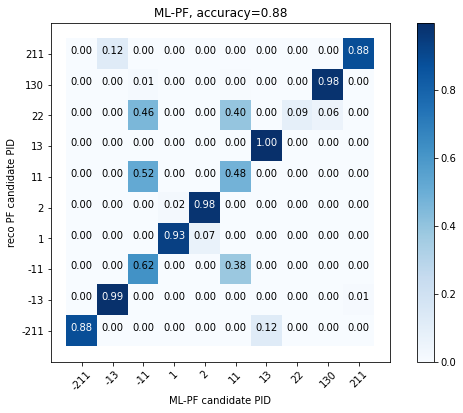

In [649]:
msk = (big_df["target_pid"] != 0) & ((big_df["pred_pid"] != 0))
#msk = np.ones(len(big_df), dtype=np.bool)
confusion2 = sklearn.metrics.confusion_matrix(
    big_df["target_pid"][msk], big_df["pred_pid"][msk],
    labels=train_end2end.class_labels[1:]
)
train_end2end.plot_confusion_matrix(
    cm=confusion2, target_names=[int(x) for x in train_end2end.class_labels][1:], normalize=True
)

acc = sklearn.metrics.accuracy_score(big_df["target_pid"][msk], big_df["pred_pid"][msk])
plt.title("ML-PF, accuracy={:.2f}".format(acc))
plt.ylabel("reco PF candidate PID")
plt.xlabel("ML-PF candidate PID")
plt.savefig("confusion_mlpf.pdf", bbox_inches="tight")

In [19]:
bins_eta = np.linspace(-4, 4, 21)
bins_e = np.logspace(-1, 3, 21)

In [482]:
def get_eff(df, target_pid=None):
    v0 = np.sum(df==target_pid)
    return (v0 / len(df), np.sqrt(v0)/len(df))
    vals = big_df[(big_df["gen_pid"]==pid)].groupby(bs)["cand_pid"].apply(get_eff, target_pid=pid)


In [483]:
def get_effs_cand_pred(pid, by, bins):
    bs = by + "_bins"
    big_df[bs] = np.searchsorted(bins, big_df[by])
    
    vals = big_df[(big_df["gen_pid"]==pid)].groupby(bs)["cand_pid"].apply(get_eff, target_pid=pid)
    xs1 = [bins[min(k, len(bins)-1)] for k in vals.keys()][:-1]
    ys1 = [v[0] for v in vals.values][:-1]
    es1 = [v[1] for v in vals.values][:-1]

    vals = big_df[(big_df["gen_pid"]==pid)].groupby(bs)["pred_pid"].apply(get_eff, target_pid=pid)
    xs2 = [bins[min(k, len(bins)-1)] for k in vals.keys()][:-1]
    ys2 = [v[0] for v in vals.values][:-1]
    es2 = [v[1] for v in vals.values][:-1]
    
    return xs1, (ys1, es1), (ys2, es2)

In [19]:
#for pid in [211, -211, 130, 22, 1, 2, -11, 11]:
for pid in [211, -211, 130, 22, 11, -11, 1, 2]:
    plt.figure(figsize=(4,4))
    xs, (ys1, es1), (ys2, es2) = get_effs_cand_pred(pid, "gen_e", bins_e)
    plt.errorbar(xs, ys1, es1, lw=1, elinewidth=1, marker=".", label="standard PF")
    plt.errorbar(xs, ys2, es2, lw=1, elinewidth=1, marker=".", label="ML-PF")
    plt.legend(frameon=False)
    plt.ylim(0, 1.5)
    plt.xscale("log")
    plt.xlabel("gen E")
    plt.ylabel("reconstruction efficiency")
    plt.title("pid={}".format(pid))
    plt.savefig("eff_pt_pid{}.pdf".format(pid), bbox_inches="tight")

    plt.figure(figsize=(4,4))
    xs, (ys1, es1), (ys2, es2) = get_effs_cand_pred(pid, "gen_eta", bins_eta)
    plt.errorbar(xs, ys1, es1, lw=1, elinewidth=1, marker=".", label="standard PF")
    plt.errorbar(xs, ys2, es2, lw=1, elinewidth=1, marker=".", label="ML-PF")
    plt.legend(frameon=False)
    plt.ylim(0, 1.5)
    plt.xlabel("gen eta")
    plt.ylabel("reconstruction efficiency")
    plt.title("pid={}".format(pid))
    plt.savefig("eff_eta_pid{}.pdf".format(pid), bbox_inches="tight")

NameError: name 'get_effs_cand_pred' is not defined

<Figure size 288x288 with 0 Axes>

In [64]:
def make_plot_reg(big_df, pid, pred_type, val, bins):

    m = big_df[(big_df["cand_pid"]==pid) & (big_df["{}_pid".format(pred_type)]==pid)][["cand_{}".format(val), "{}_{}".format(pred_type, val)]].values
    corr = np.corrcoef(m[:, 0], m[:, 1])[0,1]
    
    plt.figure(figsize=(4,4))
    plt.hist(m[:, 0], bins=bins, histtype="step", lw=2, label="true")
    plt.hist(m[:, 1], bins=bins, histtype="step", lw=2, label="pred")
    plt.xlabel(val)
    plt.legend(frameon=False)
    plt.savefig("pred_{}_{}_{}.pdf".format(val, pred_type, pid), bbox_inches="tight")

    ngen = np.sum((big_df["cand_pid"]==pid))
    eff = np.sum((big_df["cand_pid"]==pid) & (big_df["{}_pid".format(pred_type)]==pid)) / float(np.sum((big_df["cand_pid"]==pid)))
    fake = np.sum((big_df["cand_pid"]!=pid) & (big_df["{}_pid".format(pred_type)]==pid)) / float(np.sum((big_df["{}_pid".format(pred_type)]==pid)))

    plt.figure(figsize=(4,4))
    plt.title("ngen={} corr={:.2f}\neff={:.2f} fake={:.2f}".format(ngen, corr, eff, fake))
    h = np.histogram2d(m[:, 0], m[:, 1], bins=(bins, bins))
    mplhep.hist2dplot(h[0], h[1], h[2], cmap="Blues", cbar=False)
    plt.xlabel("True {}".format(val))
    plt.ylabel("Predicted {}".format(val))
    plt.savefig("pred_corr_{}_{}_{}.pdf".format(val, pred_type, pid), bbox_inches="tight")

    plt.figure(figsize=(4,4))
    var = np.abs(m[:, 1] / m[:, 0])
    var[var > 100] = 100
    var[var < 0] = 0
    plt.hist(var, bins=np.linspace(0.5, 1.5, 101))
    plt.xlabel("true {} / predicted {}".format(val, val))
    plt.title("mu={:.4f} s={:.4f}".format(np.mean(var), np.std(var)))
    plt.savefig("pred_ratio_{}_{}_{}.pdf".format(val, pred_type, pid), bbox_inches="tight")
    #plt.axvline(1.0, color="black")
    ##plt.yscale("log")

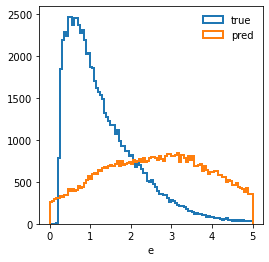

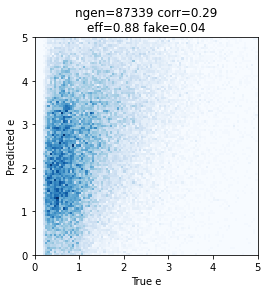

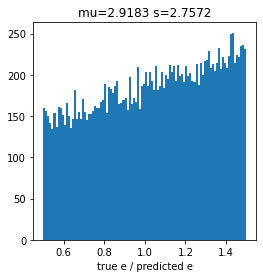

In [131]:
bins = np.linspace(0, 5, 101)
pid = 211
val = "e"

#make_plot_reg(big_df, pid, "cand", val, bins)
make_plot_reg(big_df, pid, "pred", val, bins)

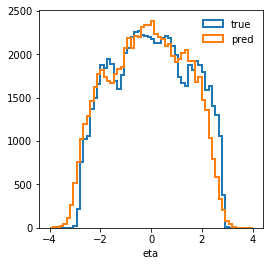

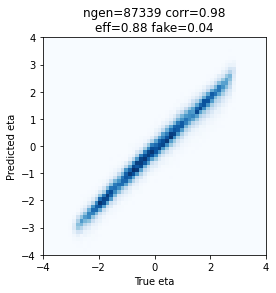

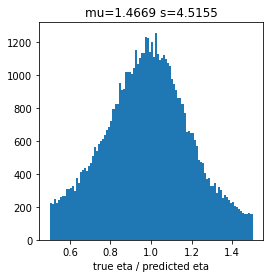

In [133]:
bins = np.linspace(-4, 4, 61)
pid = 211
val = "eta"

#make_plot_reg(big_df, pid, "cand", val, bins)
make_plot_reg(big_df, pid, "pred", val, bins)

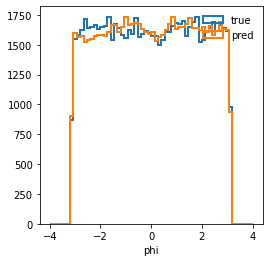

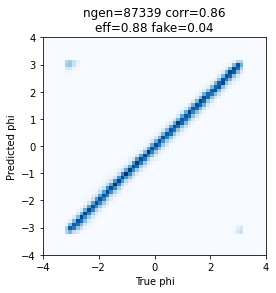

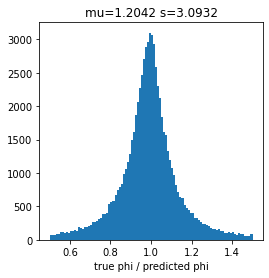

In [134]:
bins = np.linspace(-4, 4, 61)
pid = 211
val = "phi"

#make_plot_reg(big_df, pid, "cand", val, bins)
make_plot_reg(big_df, pid, "pred", val, bins)

In [ ]:
# n_preds = []
# n_trues = []
# for i in range(len(pred_ids)):
#     n_true = np.sum(true_ids[i]!=0)
#     n_pred = np.sum(pred_ids[i]!=0)
#     n_preds += [n_pred]
#     n_trues += [n_true]

In [ ]:
# plt.figure(figsize=(5, 5))
# ax = plt.axes()
# plt.plot([1500,5000],[1500,5000], color="black", lw=0.5)
# plt.scatter(n_trues, n_preds, marker=".", alpha=0.5)
# plt.xlim(1500,5000)
# plt.ylim(1500,5000)
# plt.xlabel("Number of Target PF Candidates",fontsize=13)
# plt.ylabel("Number of Predicted GNN Candidates",fontsize=13)
# #plt.title("QCD Run3")

# plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
# plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
# #plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.tight_layout()
# #plt.savefig("num_pred.pdf")

In [ ]:
# cms = []
# for i in range(len(pred_ids)):
#     cm = sklearn.metrics.confusion_matrix(
#         true_ids[i],
#         pred_ids[i], labels=range(len(train_end2end.class_labels))
#     )
#     cms += [cm]
# cm = sum(cms)
# cm = cm / 1000.0
# cm = np.round(cm, 1)#.astype(np.int)

In [ ]:
# train_end2end.plot_confusion_matrix(cm, [int(x) for x in train_end2end.class_labels], normalize=True)
# #plt.xlim(-0.5, 9.5)
# #plt.ylim(-0.5, 9.5)
# plt.title("Normalized Confusion Matrix (QCD Run3)")
# #plt.text(0.02, 0.98, "CMS Simulation, preliminary", transform=ax.transAxes, va="top", ha="left")
# #plt.tight_layout()
# plt.savefig("cm.pdf")

In [ ]:
# pm = np.concatenate(pred_momenta)
# tm = np.concatenate(true_momenta)
# ti = np.concatenate(true_ids)
# pi = np.concatenate(pred_ids)


# pm[:, 0] = np.power(10, pm[:, 0])
# tm[:, 0] = np.power(10, tm[:, 0])

In [ ]:
# plt.figure(figsize=(5, 5))

# ax = plt.axes()
# bins = np.linspace(0, 50, 100)
# h0 = plt.hist(pm[pi!=0, 0], bins=bins, histtype="step", lw=1, label="PF");
# h1 = plt.hist(tm[ti!=0, 0], bins=bins, histtype="step", lw=1, label="GNN");
# plt.yscale("log")
# plt.legend(frameon=False)
# plt.ylim(10, 1e7)

# plt.xlabel("Candidate $p_{\mathrm{T}}$ (a.u.)",fontsize=13)
# plt.ylabel("Number of Candidates",fontsize=13)
# #plt.title("QCD Run 3")

# plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
# plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
# #plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.tight_layout()
# plt.savefig("pt_hist.pdf")

In [ ]:
# plt.figure(figsize=(5, 5))
# ax = plt.axes()

# bins = np.linspace(-4, 4, 100)
# plt.hist(pm[pi!=0, 1], bins=bins, histtype="step", lw=1);
# plt.hist(tm[ti!=0, 1], bins=bins, histtype="step", lw=1);
# plt.yscale("log")

# plt.ylim(1000, 1e6)
# plt.xlabel("Candidate $\eta$ (a.u.)",fontsize=13)
# plt.ylabel("Number of Candidates",fontsize=13)
# #plt.title("QCD Run 3")
# plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
# plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
# #plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.tight_layout()
# plt.savefig("eta_hist.pdf")

In [ ]:
# plt.figure(figsize=(5, 5))

# ax = plt.axes()
# bins = np.linspace(-3, 3, 60)
# plt.hist(pm[pi!=0, 2], bins=bins, histtype="step", lw=1);
# plt.hist(tm[ti!=0, 2], bins=bins, histtype="step", lw=1);
# plt.yscale("log")
# plt.ylim(1000, 1e6)

# plt.xlabel("Candidate $\phi$ (a.u.)",fontsize=13)
# plt.ylabel("Number of Candidates",fontsize=13)
# #plt.title("QCD Run 3")

# plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
# plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
# #plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.tight_layout()
# plt.savefig("phi_hist.pdf")

In [ ]:
# plt.figure(figsize=(5, 5))
# ax = plt.axes()

# subidx = np.where((pi!=0)&(ti!=0))[0]
# rp = np.random.permutation(range(len(subidx)))[:1000]

# plt.scatter(pm[subidx[rp], 0], tm[subidx[rp], 0], marker=".", alpha=0.5)
# plt.xlim(0,2)
# plt.ylim(0,2)
# plt.plot([0,2],[0,2], color="black")

# plt.xlabel("Target PF Candidate $p_{\mathrm{T}}$ (a.u.)",fontsize=13)
# plt.ylabel("Predicted GNN Candidate $p_{\mathrm{T}}$ (a.u.)", fontsize=13)
# #plt.title("QCD Run 3, 1000 candidates")

# plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
# plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
# #plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.tight_layout()
# plt.savefig("pt_corr.pdf")

In [ ]:
# plt.figure(figsize=(5, 5))
# ax = plt.axes()

# plt.plot([-7, 7], [-7, 7], color="black", lw=0.5)
# plt.scatter(pm[subidx[rp], 1], tm[subidx[rp], 1], marker=".", alpha=0.5)
# plt.xlim(-7, 7)
# plt.ylim(-7, 7)

# plt.xlabel("Target PF Candidate $\eta$ (a.u.)",fontsize=13)
# plt.ylabel("Predicted GNN Candidate $\eta$ (a.u.)",fontsize=13)
# #plt.title("QCD Run 3, 1000 candidates")
# plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
# plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
# #plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.tight_layout()
# plt.savefig("eta_corr.pdf")

In [ ]:
# plt.figure(figsize=(5, 5))
# ax = plt.axes()

# plt.plot([-5, 5], [-5, 5], color="black", lw=0.5)
# plt.scatter(pm[subidx[rp], 2], tm[subidx[rp], 2], marker=".", alpha=0.5)
# plt.xlim(-3,3)
# plt.ylim(-3,3)


# plt.xlabel("Target PF Candidate $\phi$ (a.u.)",fontsize=13)
# plt.ylabel("Predicted GNN Candidate $\phi$ (a.u.)",fontsize=13)
# #plt.title("QCD Run3, 1000 candidates")

# plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
# plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
# #plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.tight_layout()
# plt.savefig("phi_corr.pdf")

In [ ]:
# import pandas as pd
# import tqdm

# import matplotlib as mpl
# mpl.rcParams['figure.figsize'] = [8.0, 6.0]
# mpl.rcParams['font.size'] = 12
# mpl.rcParams['legend.fontsize'] = 'large'
# mpl.rcParams['figure.titlesize'] = 'medium'

# d = full_dataset.get(1)
# d.batch = torch.zeros((len(d.x)), dtype=torch.long)
# d = d.to(device=device)
# train_end2end.data_prep(d, device=device)
# edges, cand_id_onehot, cand_momentum = model(d)
# output = edges.detach().cpu().numpy()
# d = full_dataset.get(1)
# x_data = d.x.detach().cpu().numpy()
# mask = ((x_data[:,4]==0) & (x_data[:,5]==0) & (x_data[:,6]==0) & (x_data[:,7]==0))
# good_index = np.zeros((x_data.shape[0],1,2),dtype=int)
# good_x = x_data[:,2:4].copy()                                                                            
# good_x[~mask] = x_data[~mask,2:4].copy()
# df = pd.DataFrame(good_x, columns=['eta','phi'])
# df['isTrack'] = ~mask
# row, col = d.edge_index.cpu().detach().numpy()
# y_truth = d.ycand.cpu().detach().numpy()

# min_phi = -1.25
# max_phi = 1.25
# min_eta = -1.25
# max_eta = 1.25
# extra = 1.0
# x = 'eta'
# y = 'phi'
# for plot_type in [['input'],['truth'],['output']]: 
#     k = 0
#     plt.figure(figsize=(8, 6))                        
#     for i, j in tqdm.tqdm(zip(row, col),total=len(y_truth)):
#         x1 = df[x][i]
#         x2 = df[x][j]
#         y1 = df[y][i]
#         y2 = df[y][j]
#         if (x1 < min_eta-extra or x1 > max_eta+extra) or (x2 < min_eta-extra or x2 > max_eta+extra): continue
#         if (y1 < min_phi-extra or y1 > max_phi+extra) or (y2 < min_phi-extra or y2 > max_phi+extra): continue
#         if 'input' in plot_type:
#             seg_args = dict(c='b',alpha=0.1,zorder=1)
#             plt.plot([df[x][i], df[x][j]],
#                  [df[y][i], df[y][j]], '-', **seg_args)
#         if 'truth' in plot_type and y_truth[k]:
#             seg_args = dict(c='r',alpha=0.8,zorder=2)
#             plt.plot([df[x][i], df[x][j]],
#                  [df[y][i], df[y][j]], '-', **seg_args)
#         if 'output' in plot_type:
#             seg_args = dict(c='g',alpha=output[k].item(),zorder=3)
#             plt.plot([df[x][i], df[x][j]],
#                  [df[y][i], df[y][j]], '-', **seg_args)
#         k+=1
#     cut_mask = (df[x] > min_eta-extra) & (df[x] < max_eta+extra) & (df[y] > min_phi-extra) & (df[y] < max_phi+extra)
#     cluster_mask = cut_mask & ~df['isTrack']
#     track_mask = cut_mask & df['isTrack']
#     plt.scatter(df[x][cluster_mask], df[y][cluster_mask],c='g',marker='o',s=50,zorder=4,alpha=1)
#     plt.scatter(df[x][track_mask], df[y][track_mask],c='b',marker='p',s=50,zorder=5,alpha=1)
#     plt.xlabel("Track or Cluster $\eta$",fontsize=18)
#     plt.ylabel("Track or Cluster $\phi$",fontsize=18)
#     plt.xlim(min_eta, max_eta)
#     plt.ylim(min_phi, max_phi)
#     plt.figtext(0.12, 0.90,'CMS',fontweight='bold', wrap=True, horizontalalignment='left', fontsize=20)
#     plt.figtext(0.22, 0.90,'Simulation Preliminary', style='italic', wrap=True, horizontalalignment='left', fontsize=18)
#     plt.figtext(0.67, 0.90,'Run 3 (14 TeV)',  wrap=True, horizontalalignment='left', fontsize=18)
#     plt.savefig('graph_%s_%s_%s.pdf'%(x,y,'_'.join(plot_type)))

In [17]:
import pickle

In [19]:
d = pickle.load(open("../data/TTbar_14TeV_TuneCUETP8M1_cfi_v2/raw/pfntuple_1000_0.pkl", "rb"))

In [21]:
ev = d[0]

In [23]:
Xelem = ev["Xelem"]
ycand = ev["ycand"]

In [26]:
np.unique(Xelem[ycand[:, 0]==22, 0], return_counts=True)

(array([4., 5.], dtype=float32), array([267,   1]))